In [1]:
!pip install wordcloud


In [2]:
import pandas as pd
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from flask import Flask, request, jsonify
import pickle

In [3]:
# Load the dataset
df = pd.read_csv("C:/Users/HP/Downloads/sms+spam+collection/SMSSpamCollection", sep='\t', header=None, names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# 2. Data Preprocessing
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    return text

df['message'] = df['message'].apply(preprocess_text)

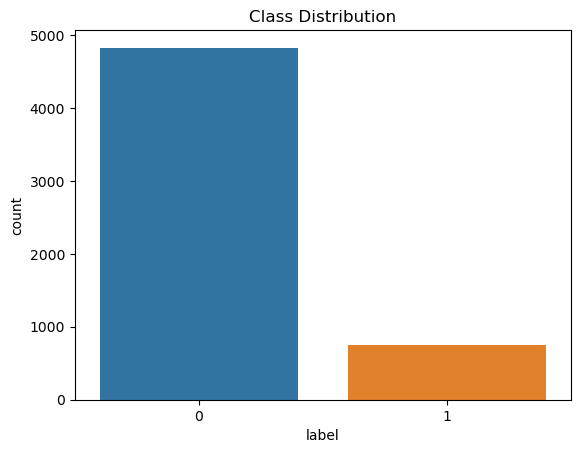

In [5]:
# 3. Exploratory Data Analysis (EDA)
# Plot class distribution
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

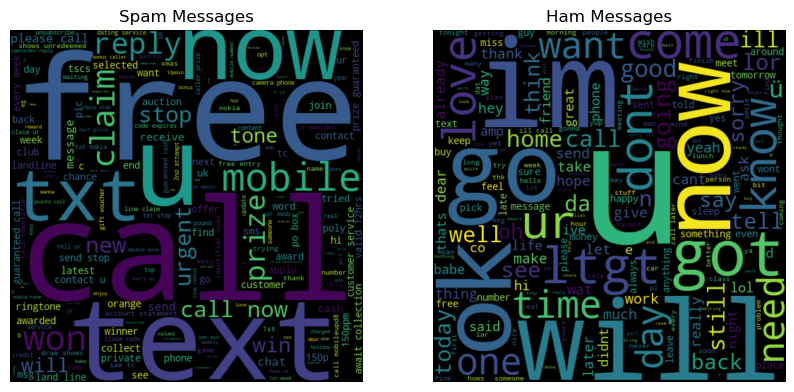

In [6]:
# Word cloud for spam and ham messages
spam_words = ' '.join(list(df[df['label'] == 1]['message']))
ham_words = ' '.join(list(df[df['label'] == 0]['message']))

spam_wc = WordCloud(width=500, height=500).generate(spam_words)
ham_wc = WordCloud(width=500, height=500).generate(ham_words)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(spam_wc, interpolation='bilinear')
plt.title('Spam Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wc, interpolation='bilinear')
plt.title('Ham Messages')
plt.axis('off')

plt.show()

In [7]:
# 4. Feature Engineering
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['message']).toarray()
y = df['label']

In [8]:
# 5. Model Training and Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Initial Model Evaluation")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Initial Model Evaluation
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115

[[965   1]
 [ 38 111]]


In [9]:
# 6. Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

print("Best Parameters: ", grid.best_params_)
y_pred = grid.predict(X_test)
print("Model Evaluation after Hyperparameter Tuning")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=   0.4s
[CV] END ..............................................C=0.1; total time=   0.6s
[CV] END ..............................................C=0.1; total time=   0.5s
[CV] END ..............................................C=0.1; total time=   0.4s
[CV] END ..............................................C=0.1; total time=   0.4s
[CV] END ................................................C=1; total time=   0.7s
[CV] END ................................................C=1; total time=   0.7s
[CV] END ................................................C=1; total time=   0.8s
[CV] END ................................................C=1; total time=   0.8s
[CV] END ................................................C=1; total time=   0.8s
[CV] END ...............................................C=10; total time=   1.3s
[CV] END ........................................

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time=   2.5s
Best Parameters:  {'C': 100}
Model Evaluation after Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.92      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

[[964   2]
 [ 12 137]]


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the trained Random Forest model and vectorizer
with open('rf_spam_classifier.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('vectorizer.pkl', 'rb') as vec_file:
    vectorizer = pickle.load(vec_file)

# Function to predict if a message is spam or not
def predict_message(message):
    message_vec = vectorizer.transform([message])
    prediction = model.predict(message_vec)[0]
    return 'Spam' if prediction == 1 else 'Not Spam'

# Sample messages of prediction
sample_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.",
    "Hey, are we still meeting at 10am tomorrow?",
    "Free entry in 2 a weekly competition to win FA Cup tickets.",
    "You've won a $1000 Amazon gift card.",
    "Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!",
    "Dear, will call tomorrow. Please accommodate."
]

# Display sample messages and their predictions
print("Sample Messages and Predictions:")
for message in sample_messages:
    print(f"Message: {message}")
    print(f"Prediction: {predict_message(message)}\n")

# Allow user to input their own messages and get the prediction
while True:
    user_message = input("Enter a message to predict (or type 'exit' to quit): ")
    if user_message.lower() == 'exit':
        break
    print(f"Prediction: {predict_message(user_message)}\n")


Sample Messages and Predictions:
Message: Congratulations! You've won a $1000 Walmart gift card. Go to http://bit.ly/12345 to claim now.
Prediction: Spam

Message: Hey, are we still meeting at 10am tomorrow?
Prediction: Not Spam

Message: Free entry in 2 a weekly competition to win FA Cup tickets.
Prediction: Not Spam

Message: You've won a $1000 Amazon gift card.
Prediction: Not Spam

Message: Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed £1000 cash or £5000 prize!
Prediction: Spam

Message: Dear, will call tomorrow. Please accommodate.
Prediction: Not Spam

